# Environment Import

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT, SparseVector
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, collect_list, split, explode, udf, avg

# Part 1: Init Spark Session with Ratings

In [10]:
def init_spark_session_with_ratings(filename):
    """
    Reads the ratings file and returns the SparkSession and DataFrame created from the file.

    Args:
    filename (str): The path to the ratings file.

    Returns:
    SparkSession, DataFrame: The Spark session and the DataFrame created from the ratings file.
    """

    # Initialize Spark session
    spark = SparkSession.builder \
        .appName("MovieRecommend") \
        .config("spark.executor.memory", "32g") \
        .config("spark.executor.cores", "8") \
        .config("spark.executor.instances", "6") \
        .config("spark.driver.memory", "64g") \
        .getOrCreate()

    ratings_df = spark.read.csv("dataset/ratings.csv", header=True, inferSchema=True)
    print(ratings_df)
    ratings_df.show()

    return spark, ratings_df


spark, ratings_df = init_spark_session_with_ratings("dataset/ratings.csv")

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows



In [7]:
movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)
tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)
genome_scores_df = spark.read.csv("dataset/genome-scores.csv", header=True, inferSchema=True)
genome_tags_df = spark.read.csv("dataset/genome-tags.csv", header=True, inferSchema=True)

movies_df.show(truncate=False)
tags_df.show(truncate=False)
genome_scores_df.show(truncate=False)
genome_tags_df.show(truncate=False)

+-------+-------------------------------------+-------------------------------------------+
|movieId|title                                |genres                                     |
+-------+-------------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                     |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                       |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)              |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)             |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)   |Comedy                                     |
|6      |Heat (1995)                          |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                       |Comedy|Romance                             |
|8      |Tom and Huck (1995)                  |Adventure|Children               

In [3]:
ratings_df = spark.read.csv("dataset/ratings.csv", header=True, inferSchema=True)
print(ratings_df.count())

25000095


In [31]:
from pyspark.sql.functions import col, collect_list, udf, lit, row_number
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, FloatType
from pyspark.ml.linalg import Vectors, VectorUDT

genome_scores_df = spark.read.csv("dataset/genome-scores.csv", header=True, inferSchema=True)

# 定义UDF来取前100个最高相关性分数
take_top_n_udf = udf(lambda arr: sorted(arr, reverse=True)[:100], ArrayType(FloatType()))
genome_scores_df = genome_scores_df.groupby('movieId').agg(
    take_top_n_udf(collect_list('relevance')).alias('relevance_list')
)
genome_scores_df = genome_scores_df.orderBy('movieId')
genome_scores_df.show(truncate=False)

+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|movieId|relevance_list                                                                                                                            

In [32]:
# 判断genome_scores_df中是否包含movieId为1的电影
contains_movie_id_1 = genome_scores_df.filter(col('movieId') == 1).count() > 0
if contains_movie_id_1:
    print("genome_scores_df包含movieId为1的电影")
else:
    print("genome_scores_df不包含movieId为1的电影")

genome_scores_df包含movieId为1的电影


In [33]:
movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)

movies_df = movies_df.withColumn("split_genres", split(col("genres"), "\|"))
movies_exploded = movies_df.withColumn("genre", explode(col("split_genres")))
movies_exploded.show(truncate=False)

genre_indexer = StringIndexer(inputCol="genre", outputCol="genreIndex")
indexed_genre = genre_indexer.fit(movies_exploded).transform(movies_exploded)
genre_encoder = OneHotEncoder(inputCol="genreIndex", outputCol="genreVec")
encoded_genre = genre_encoder.fit(indexed_genre).transform(indexed_genre)

genre_aggregated = encoded_genre.groupBy("movieId").agg(collect_list("genreVec").alias("genreVecList"))
genre_aggregated.show(truncate=False)

# 转换电影类型向量
sum_vectors_udf = udf(lambda vectors: Vectors.dense(np.sum([v.toArray() for v in vectors], axis=0)), VectorUDT())
genre_aggregated = genre_aggregated.withColumn("genresVec", sum_vectors_udf("genreVecList"))
genre_aggregated.show(truncate=False)

+-------+----------------------------------+-------------------------------------------+-------------------------------------------------+---------+
|movieId|title                             |genres                                     |split_genres                                     |genre    |
+-------+----------------------------------+-------------------------------------------+-------------------------------------------------+---------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|[Adventure, Animation, Children, Comedy, Fantasy]|Adventure|
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|[Adventure, Animation, Children, Comedy, Fantasy]|Animation|
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|[Adventure, Animation, Children, Comedy, Fantasy]|Children |
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|[Adventure, Animat

In [10]:
tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)
genome_tags_df = spark.read.csv("dataset/genome-tags.csv", header=True, inferSchema=True)

tags_df = tags_df.join(genome_tags_df, tags_df.tag == genome_tags_df.tag, "inner").select(tags_df["*"])
tags_df.show(truncate=False)

tag_indexer = StringIndexer(inputCol="tag", outputCol="tagIndex")
tag_model = tag_indexer.fit(genome_tags_df)
indexed_tags_df = tag_model.transform(tags_df)
tag_encoder = OneHotEncoder(inputCols=["tagIndex"], outputCols=["tagVec"])
tag_encoder_model = tag_encoder.fit(indexed_tags_df)
tags_encoded = tag_encoder_model.transform(indexed_tags_df)

movie_tags_features = tags_encoded.groupBy('movieId').agg(collect_list('tagVec').alias('tagVectors'))
sum_vectors_udf = udf(lambda vectors: Vectors.dense(np.sum([v.toArray() for v in vectors], axis=0)), VectorUDT())
movie_tags_features = movie_tags_features.withColumn('tagFeatures', sum_vectors_udf('tagVectors'))
movie_tags_features = movie_tags_features.drop("tagVectors")
movie_tags_features.show(truncate=False)

+------+-------+-----------------------+----------+
|userId|movieId|tag                    |timestamp |
+------+-------+-----------------------+----------+
|3     |260    |classic                |1439472355|
|3     |260    |sci-fi                 |1439472256|
|4     |1732   |dark comedy            |1573943598|
|4     |1732   |great dialogue         |1573943604|
|4     |7569   |so bad it's good       |1573943455|
|4     |115569 |tense                  |1573943077|
|4     |115713 |artificial intelligence|1573942979|
|4     |115713 |philosophical          |1573943033|
|4     |115713 |tense                  |1573943042|
|4     |148426 |so bad it's good       |1573942965|
|4     |164909 |musical                |1573943714|
|4     |168250 |horror                 |1573945163|
|19    |7099   |adventure              |1445286141|
|19    |7099   |anime                  |1445286127|
|19    |7099   |ecology                |1445286153|
|19    |7099   |fantasy                |1445286144|
|19    |7099

In [11]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.linalg import VectorUDT

# 定义一个UDF来获取向量的长度
def vector_length(vector):
    return len(vector)

# 注册UDF
vector_length_udf = udf(vector_length, IntegerType())

# 应用UDF到DataFrame
movie_tags_features = movie_tags_features.withColumn("vectorLength", vector_length_udf("tagFeatures"))

# 显示结果
movie_tags_features.select("movieId", "vectorLength").show(truncate=False)

+-------+------------+
|movieId|vectorLength|
+-------+------------+
|12     |1127        |
|22     |1127        |
|26     |1127        |
|27     |1127        |
|28     |1127        |
|31     |1127        |
|34     |1127        |
|44     |1127        |
|53     |1127        |
|65     |1127        |
|76     |1127        |
|78     |1127        |
|81     |1127        |
|85     |1127        |
|101    |1127        |
|103    |1127        |
|126    |1127        |
|133    |1127        |
|137    |1127        |
|148    |1127        |
+-------+------------+
only showing top 20 rows



In [16]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf, col, explode, split, collect_list
from pyspark.sql.functions import col, collect_list, udf, lit, row_number
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, FloatType
from pyspark.ml.linalg import Vectors, VectorUDT

def feature_engineering(spark, ratings_df):
    # relevance 
    genome_scores_df = spark.read.csv("dataset/genome-scores.csv", header=True, inferSchema=True)
    take_top_n_udf = udf(lambda arr: sorted(arr, reverse=True)[:20], ArrayType(FloatType()))
    genome_scores_df = genome_scores_df.groupby('movieId').agg(
        take_top_n_udf(collect_list('relevance')).alias('relevance_list')
    )
    genome_scores_df = genome_scores_df.orderBy('movieId')
    genome_scores_df.show(truncate=False)


    # genre 
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)
    movies_df = movies_df.withColumn("split_genres", split(col("genres"), "\|"))
    movies_exploded = movies_df.withColumn("genre", explode(col("split_genres")))

    genre_indexer = StringIndexer(inputCol="genre", outputCol="genreIndex")
    indexed_genre = genre_indexer.fit(movies_exploded).transform(movies_exploded)
    genre_encoder = OneHotEncoder(inputCol="genreIndex", outputCol="genreVec")
    encoded_genre = genre_encoder.fit(indexed_genre).transform(indexed_genre)

    genre_aggregated = encoded_genre.groupBy("movieId").agg(collect_list("genreVec").alias("genreVecList"))

    sum_vectors_udf = udf(lambda vectors: Vectors.dense(np.sum([v.toArray() for v in vectors], axis=0)), VectorUDT())
    genre_aggregated = genre_aggregated.withColumn("genresVec", sum_vectors_udf("genreVecList"))
    genre_aggregated.show(truncate=False)

    # tag
    tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)
    genome_tags_df = spark.read.csv("dataset/genome-tags.csv", header=True, inferSchema=True)
    tags_df = tags_df.join(genome_tags_df, tags_df.tag == genome_tags_df.tag, "inner").select(tags_df["*"])

    tag_indexer = StringIndexer(inputCol="tag", outputCol="tagIndex")
    tag_model = tag_indexer.fit(genome_tags_df)
    indexed_tags_df = tag_model.transform(tags_df)
    tag_encoder = OneHotEncoder(inputCols=["tagIndex"], outputCols=["tagVec"])
    tag_encoder_model = tag_encoder.fit(indexed_tags_df)
    tags_encoded = tag_encoder_model.transform(indexed_tags_df)

    movie_tags_features = tags_encoded.groupBy('movieId').agg(collect_list('tagVec').alias('tagVectors'))
    sum_vectors_udf = udf(lambda vectors: Vectors.dense(np.sum([v.toArray() for v in vectors], axis=0)), VectorUDT())
    movie_tags_features = movie_tags_features.withColumn('tagFeatures', sum_vectors_udf('tagVectors'))
    movie_tags_features = movie_tags_features.drop("tagVectors")
    movie_tags_features.show(truncate=False)

    # 组合所有特征
    complete_data_df = ratings_df.join(genre_aggregated.select("movieId", "genresVec"), "movieId") \
        .join(movie_tags_features.select("movieId","tagFeatures"), "movieId") \
        .join(genome_scores_df.select('movieId', 'relevance_list'), 'movieId', 'left')
    complete_data_df = complete_data_df.orderBy('userId')
    complete_data_df.show(truncate=False)
    
    return complete_data_df


complete_data_df = feature_engineering(spark, ratings_df)


+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|movieId|relevance_list                                                                                                                                                                |
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1      |[0.99925, 0.99875, 0.99575, 0.98575, 0.98425, 0.98, 0.9645, 0.95975, 0.95475, 0.94725, 0.93675, 0.92875, 0.91625, 0.90725, 0.90375, 0.89625, 0.89375, 0.893, 0.88575, 0.87625]|
|2      |[0.976, 0.959, 0.95175, 0.95, 0.932, 0.9185, 0.879, 0.87075, 0.8685, 0.86725, 0.8495, 0.8175, 0.8145, 0.77525, 0.75375, 0.73975, 0.73225, 0.72675, 0.705, 0.6965]             |
|3      |[0.97525, 0.9625, 0.9305, 0.853, 0.75425, 0.6765, 0.6445, 0.578, 0

+-------+-----------------------------------------------------------------------------------+-----------------------------------------------------------------------------+
|movieId|genreVecList                                                                       |genresVec                                                                    |
+-------+-----------------------------------------------------------------------------------+-----------------------------------------------------------------------------+
|1      |[(19,[9],[1.0]), (19,[12],[1.0]), (19,[11],[1.0]), (19,[1],[1.0]), (19,[14],[1.0])]|[0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0]|
|2      |[(19,[9],[1.0]), (19,[11],[1.0]), (19,[14],[1.0])]                                 |[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]|
|3      |[(19,[1],[1.0]), (19,[3],[1.0])]                                                   |[0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+-------+------+------+----------+-----------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [17]:
print(complete_data_df.count())
complete_data_df = complete_data_df.na.drop(subset=["genresVec", "tagFeatures", "relevance_list"])
print(complete_data_df.count())

# 定义一个UDF将数组转换为Vector
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# 将relevance_list转换为Vector类型
complete_data_df = complete_data_df.withColumn("relevance_vector", array_to_vector_udf(col("relevance_list")))

assembler = VectorAssembler(
    inputCols=["genresVec", "tagFeatures", "relevance_vector"],
    outputCol="features"
)

data_ready = assembler.transform(complete_data_df)

# 检查转换后的 DataFrame 中是否有空的 'features' 列
if data_ready.where(col("features").isNull()).count() > 0:
    raise ValueError("Found null values in 'features' column after VectorAssembler transformation.")

data_ready.show()

24634325


24435728


+-------+------+------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|movieId|userId|rating| timestamp|           genresVec|         tagFeatures|      relevance_list|    relevance_vector|            features|
+-------+------+------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   1088|     1|   4.0|1147868495|[1.0,0.0,0.0,1.0,...|[0.0,0.0,0.0,0.0,...|[0.99525, 0.99175...|[0.99524998664855...|(1166,[0,3,17,25,...|
|  27266|     1|   4.5|1147879365|[1.0,0.0,0.0,1.0,...|[0.0,0.0,0.0,0.0,...|[0.9885, 0.966, 0...|[0.98849999904632...|(1166,[0,3,10,14,...|
|    296|     1|   5.0|1147880044|[1.0,1.0,1.0,0.0,...|[0.0,0.0,0.0,0.0,...|[0.99925, 0.9905,...|[0.99924999475479...|(1166,[0,1,2,7,37...|
|   1653|     1|   4.0|1147868097|[1.0,0.0,1.0,0.0,...|[0.0,0.0,0.0,0.0,...|[0.9995, 0.999, 0...|[0.99949997663497...|(1166,[0,2,10,104...|
|   1175|     1|   3

In [19]:
# Sampling the data
data_ready = data_ready.sample(False, 0.001)

print(data_ready.count())

24352


In [8]:
from pyspark.sql.types import StringType

data_ready.take(1)

# Define a UDF to convert vector to string for easy inspection
vec_to_string = udf(lambda vec: str(vec), StringType())

# Apply the UDF to convert the 'features' column to string
data_with_features_string = data_ready.withColumn("features_str", vec_to_string("features"))

# Show the result
data_with_features_string.select("features_str").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

23/12/01 20:22:52 WARN PythonUDFRunner: Detected deadlock while completing task 0.0 in stage 249 (TID 3659): Attempting to kill Python Worker


In [10]:
# Function to extract and display feature vector information
def extract_feature_info(feature_vector):
    # Show feature vector length (should be 1166)
    print("Feature vector length:", len(feature_vector))

    # Show the last index of the feature vector (should be 1165 for zero-based indexing)
    print("Last index value:", feature_vector.indices[-1])

# Take one example from the DataFrame and apply the function
extract_feature_info(data_ready.head().features)


Feature vector length: 1166
Last index value: 1165


In [25]:
def rf_train_evaluate(data_ready):
    """
    Train, evaluate, and visualize movie recommendations using a Random Forest model.

    Args:
    data_ready (DataFrame): DataFrame containing prepared features for training.
    """

    # Splitting the dataset
    training_features, test_features = data_ready.randomSplit([0.7, 0.3])

    # Training the Random Forest model with optimized parameters
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="rating",
        numTrees=5,            # 减少树的数量以加快训练
        maxDepth=5,             # 降低树的最大深度
        maxBins=32,
        minInstancesPerNode=1  # 每个节点的最小实例数
    )
    model = rf.fit(training_features)

    # Evaluate model on test dataset
    predictions_df = model.transform(test_features)
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Calculate and output evaluation metrics
    rmse = rmse_evaluator.evaluate(predictions_df)
    mae = mae_evaluator.evaluate(predictions_df)
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    return predictions_df

predictions_df = rf_train_evaluate(data_ready)
predictions_df.show()

Root Mean Square Error (RMSE): 0.9951233309228193
Mean Absolute Error (MAE): 0.786046399092221


+-------+------+------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|movieId|userId|rating| timestamp|           genresVec|         tagFeatures|      relevance_list|    relevance_vector|            features|        prediction|
+-------+------+------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|      7|   122|   4.0| 848692767|[0.0,1.0,0.0,1.0,...|[0.0,0.0,0.0,0.0,...|[0.98125, 0.96225...|[0.98124998807907...|(1166,[1,3,127,21...|3.1588841802775653|
|     47|   155|   4.0|1196554584|[0.0,0.0,1.0,0.0,...|[0.0,0.0,0.0,0.0,...|[0.99375, 0.98525...|[0.99374997615814...|(1166,[2,13,104,1...| 4.033920122685735|
|    160|  1164|   2.0| 842549804|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[0.98625, 0.977, ...|[0.98624998331069...|(1166,[4,9,10,13,...|  3.03986986390674|
|    173|   983|   1.5|1078585598|[0.0,0.0,0.0

23/12/02 01:14:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/02 01:14:26 WARN RowBasedKeyValueBatch: Calling spill() on

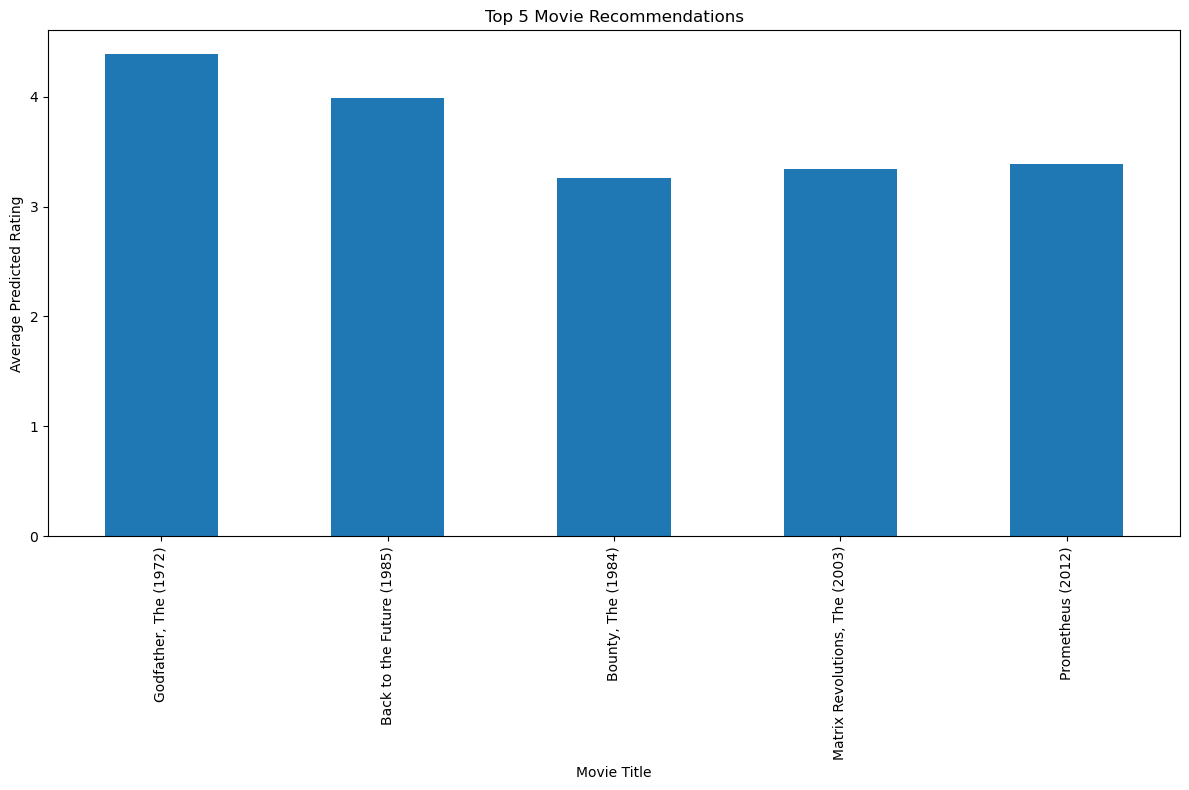

In [26]:
def rf_recommend_visualization(predictions_df):
    top_predictions = predictions_df.groupBy('movieId').agg({'prediction': 'avg'}).withColumnRenamed('avg(prediction)', 'average_rating').limit(5)

    # Join with the movies dataframe to get movie titles
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)  # Load movies data
    top_movies_with_titles = top_predictions.join(movies_df, 'movieId').select('title', 'average_rating')  # Use 'average_rating' here

    # Convert to pandas dataframe for visualization
    top_movies_pd = top_movies_with_titles.toPandas()
    top_movies_pd.set_index('title', inplace=True)

    # Plot
    plt.figure(figsize=(12, 8))
    top_movies_pd['average_rating'].plot(kind='bar')  # Use 'average_rating' here
    plt.xlabel('Movie Title')
    plt.ylabel('Average Predicted Rating')  # Update the ylabel
    plt.title('Top 5 Movie Recommendations')
    plt.tight_layout()
    plt.show()
    plt.close()

rf_recommend_visualization(predictions_df)